# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Cristóbal Tomás David Alberto Lagos Valtierra

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [94]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import cupy as cp

## Subir datasets de dígitos (train)

In [95]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

In [96]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

## Leer dataset de dígitos

In [97]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [98]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [99]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [100]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [101]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0,0,9,14,9,0,0,0,0,6,...,0,0,0,6,10,14,16,5,0,9
1548,0,0,4,16,16,9,0,0,0,0,...,0,0,0,5,13,16,15,0,0,3
1709,0,0,3,14,15,9,0,0,0,0,...,0,0,0,2,10,16,16,2,0,1
2195,0,2,14,10,1,0,0,0,0,6,...,0,0,2,13,9,8,9,7,0,2
1216,0,2,9,15,16,15,2,0,0,11,...,0,0,0,12,16,15,9,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0,0,0,2,9,16,3,0,0,0,...,0,0,0,0,0,14,3,0,0,9
1180,0,1,8,10,14,10,0,0,0,12,...,0,0,0,12,16,14,12,4,0,3
3441,0,0,4,11,16,11,1,0,0,3,...,0,0,0,6,14,0,0,0,0,9
1344,0,0,11,16,16,7,0,0,0,2,...,1,0,0,10,16,16,16,16,10,2


In [102]:
#normalización de datasets
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-102-5a2d17882318>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-102-5a2d17882318>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-102-5a2d17882318>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if c

## Crear modelo

## Crear datasets y dataloaders para pytorch (train)

In [103]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
#dataset de entrenamiento
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
#dataset de validación
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
#dataset de prueba
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [104]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [105]:
def train_model(model_to_train):
    # Listas para almacenar el loss y el tiempo
    train_losses = []
    val_losses = []
    times = []

    # Inicialización de variables para el seguimiento del loss de validación
    prev_val_loss = float('inf')  # Inicialmente, un valor alto
    prev_train_loss = float('-inf') # Inicialmente, un valor bajo
    start = time.time()

    for epoch in range(1000):
        all_predictions_train = []
        all_labels_train = []
        model_to_train.train()

        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(dataloader_train, 0):
            # Process the current batch
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model_to_train(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calcula la precisión en entrenamiento
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_predictions_train.extend(predicted.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

        train_accuracy = 100 * correct_train / total_train

        # Mueve las predicciones y etiquetas a NumPy arrays
        predicted_train = np.array(all_predictions_train)
        labels_train = np.array(all_labels_train)

        # Calcula la matriz de confusión en la GPU
        confusion_matrix_train = confusion_matrix(labels_train, predicted_train, normalize="true")

        all_predictions_val = []
        all_labels_val = []

        model_to_train.eval()
        with torch.no_grad():
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            for i, data in enumerate(dataloader_val, 0):

                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model_to_train(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calcula la precisión en validación
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_predictions_val.extend(predicted.cpu().numpy())
                all_labels_val.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct_val / total_val

        # Mueve las predicciones y etiquetas a NumPy arrays
        predicted_gpu = np.array(all_predictions_val)
        labels_gpu = np.array(all_labels_val)

        # Calcula la matriz de confusión en la GPU
        confusion_matrix_val = confusion_matrix(labels_gpu, predicted_gpu, normalize="true")

        # Comprueba si el loss de validación aumentó y el de entrenamiento bajó
        if val_loss > prev_val_loss and train_loss < prev_train_loss:
            # Agrega el loss y el tiempo a las listas
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            times.append(time.time() - start)
            print('Deteniendo el entrenamiento en la época %d, debido al aumento en el loss de validación y la disminución en el loss de entrenamiento.' % (epoch))
            break

        prev_val_loss = val_loss
        prev_train_loss = train_loss

        # Agrega el loss y el tiempo a las listas
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        times.append(time.time() - start)

        # Imprime el loss de entrenamiento y validación, así como las precisiones
        print('epoch %d, Train Loss: %.6f, Validation Loss: %.6f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (epoch, train_loss, val_loss, train_accuracy, val_accuracy))

    end = time.time()

        # Crear una paleta de colores personalizada con una resistencia más baja
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    print('Finished Training, total time %f seconds' % (end - start))
    # Grafica el loss de entrenamiento y validación en función del tiempo
    print("Training and validation Loss Over Time")
    plt.figure(figsize=(8, 5))
    plt.plot(times, train_losses, label='Training Loss')
    plt.plot(times, val_losses, label='Validation Loss')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Time')
    plt.grid()
    plt.show()

    # Muestra la matriz de confusión del conjunto de entrenamiento con colores
    print("Normalized Confusion Matrix for training dataset")
    plt.figure(figsize=(8, 5))
    sns.heatmap(confusion_matrix_train, annot=True, cmap=cmap, fmt=".2%", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix (Accuracy - Training: {:.2f}%)'.format(train_accuracy))
    plt.show()

    print("Normalized Confusion Matrix for validation dataset")
    # Muestra la matriz de confusión del conjunto de validación con colores
    plt.figure(figsize=(8, 5))
    sns.heatmap(confusion_matrix_val, annot=True, cmap=cmap, fmt=".2%", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix (Accuracy - Validation: {:.2f}%)'.format(val_accuracy))
    plt.show()


epoch 0, Train Loss: 53.409520, Validation Loss: 23.356685, Train Accuracy: 23.90%, Validation Accuracy: 30.27%
epoch 1, Train Loss: 48.711541, Validation Loss: 21.212459, Train Accuracy: 39.61%, Validation Accuracy: 45.82%
epoch 2, Train Loss: 43.883929, Validation Loss: 18.841642, Train Accuracy: 50.56%, Validation Accuracy: 56.55%
epoch 3, Train Loss: 38.941616, Validation Loss: 16.734115, Train Accuracy: 58.51%, Validation Accuracy: 65.44%
epoch 4, Train Loss: 34.080675, Validation Loss: 14.523054, Train Accuracy: 68.08%, Validation Accuracy: 74.02%
epoch 5, Train Loss: 29.567541, Validation Loss: 12.480492, Train Accuracy: 74.29%, Validation Accuracy: 78.01%
epoch 6, Train Loss: 25.663721, Validation Loss: 10.793106, Train Accuracy: 77.55%, Validation Accuracy: 80.69%
epoch 7, Train Loss: 22.426319, Validation Loss: 9.348570, Train Accuracy: 79.72%, Validation Accuracy: 82.38%
epoch 8, Train Loss: 19.842741, Validation Loss: 8.603910, Train Accuracy: 81.59%, Validation Accuracy: 8

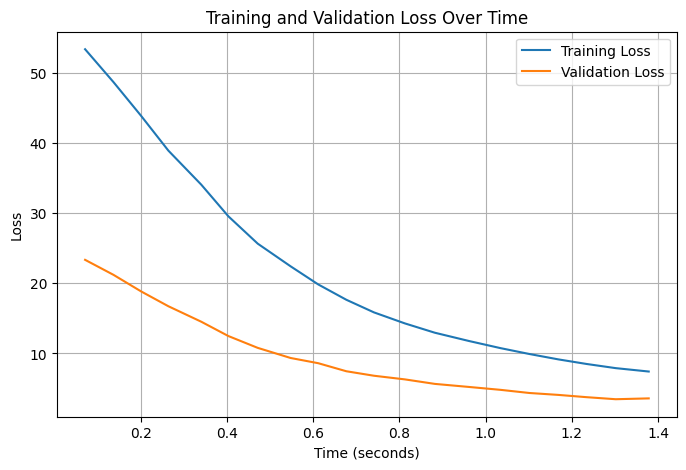

Normalized Confusion Matrix for training dataset


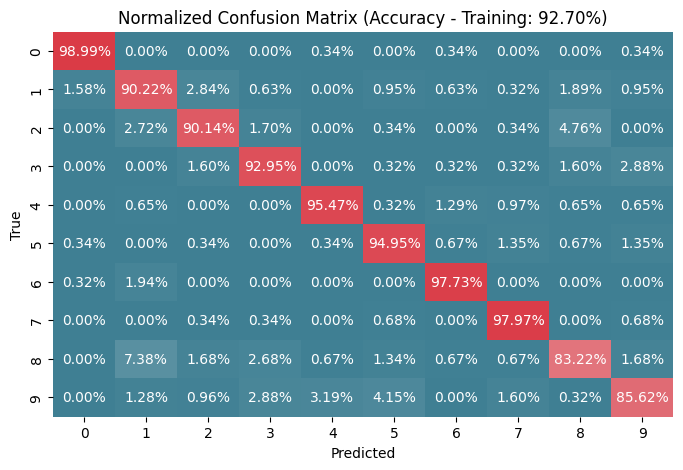

Normalized Confusion Matrix for validation dataset


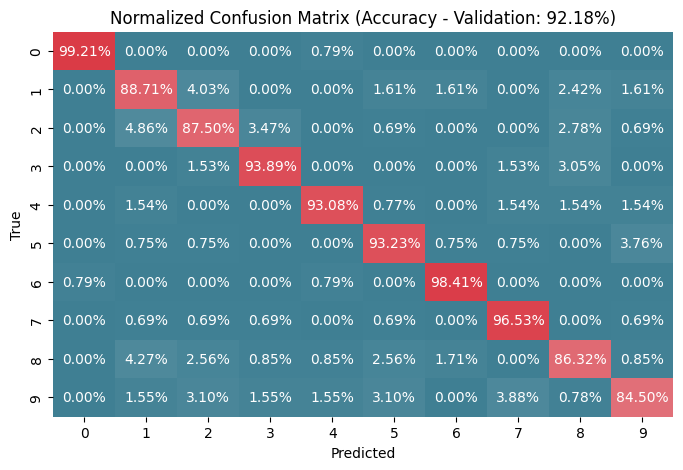

In [106]:
model_10_ReLu = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )
device = torch.device('cuda') #crea un objeto de dispositivo que representa la GPU

model = model_10_ReLu.to(device) #mueve el modelo a la GPU

criterion = nn.CrossEntropyLoss() #se crea una instancia de la función de pérdida nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Se crea un optimizador Adam (un algoritmo de optimización)
                                                          #que se utilizará para ajustar los pesos del modelo durante el entrenamiento.
train_model(model_10_ReLu)

epoch 0, Train Loss: 51.165905, Validation Loss: 20.987652, Train Accuracy: 33.53%, Validation Accuracy: 60.08%
epoch 1, Train Loss: 40.735053, Validation Loss: 15.974930, Train Accuracy: 68.87%, Validation Accuracy: 75.40%
epoch 2, Train Loss: 30.142370, Validation Loss: 11.475913, Train Accuracy: 78.17%, Validation Accuracy: 81.84%
epoch 3, Train Loss: 21.419783, Validation Loss: 8.351673, Train Accuracy: 85.70%, Validation Accuracy: 88.97%
epoch 4, Train Loss: 15.212746, Validation Loss: 5.911485, Train Accuracy: 90.24%, Validation Accuracy: 91.65%
epoch 5, Train Loss: 11.242342, Validation Loss: 4.570879, Train Accuracy: 92.11%, Validation Accuracy: 92.80%
epoch 6, Train Loss: 8.771995, Validation Loss: 3.654616, Train Accuracy: 93.20%, Validation Accuracy: 93.56%
epoch 7, Train Loss: 7.191717, Validation Loss: 3.116275, Train Accuracy: 94.41%, Validation Accuracy: 93.79%
epoch 8, Train Loss: 6.114707, Validation Loss: 2.736445, Train Accuracy: 95.13%, Validation Accuracy: 94.41%
e

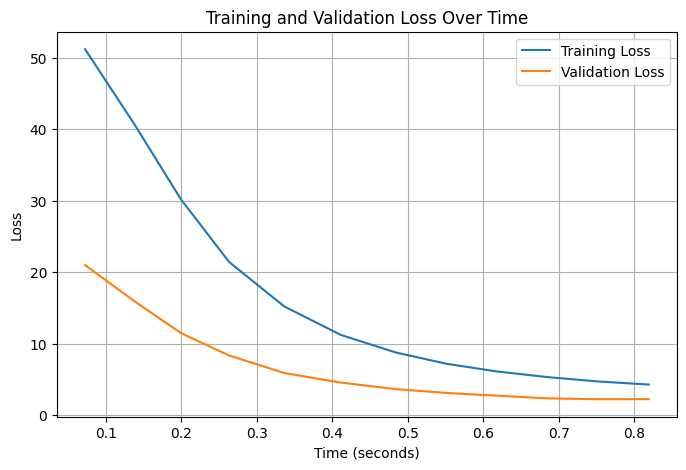

Normalized Confusion Matrix for training dataset


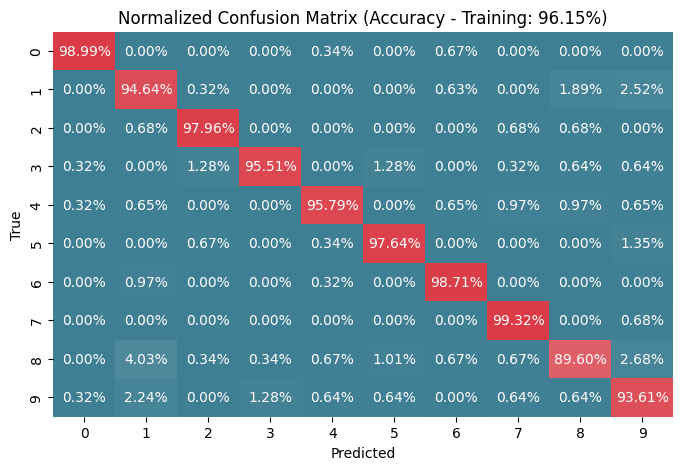

Normalized Confusion Matrix for validation dataset


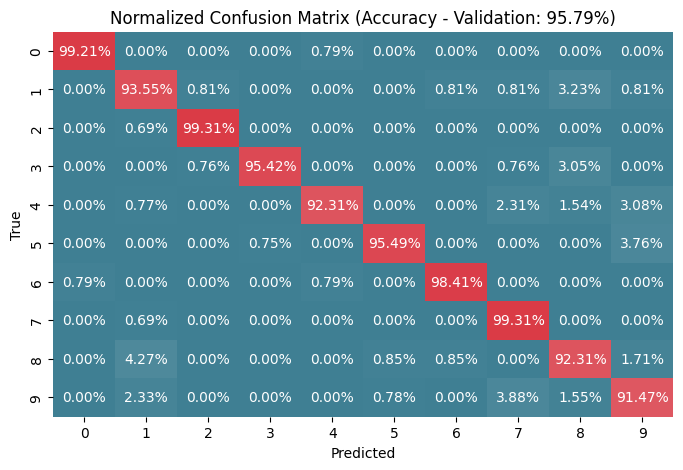

In [107]:
model_40_ReLU = nn.Sequential(
          nn.Linear(64, 40),
          nn.ReLU(),
          nn.Linear(40,10)
        )
device = torch.device('cuda') #crea un objeto de dispositivo que representa la GPU

model = model_40_ReLU.to(device) #mueve el modelo a la GPU

criterion = nn.CrossEntropyLoss() #se crea una instancia de la función de pérdida nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Se crea un optimizador Adam (un algoritmo de optimización)
                                                          #que se utilizará para ajustar los pesos del modelo durante el entrenamiento.
train_model(model_40_ReLU)

epoch 0, Train Loss: 53.641080, Validation Loss: 23.006586, Train Accuracy: 24.79%, Validation Accuracy: 34.56%
epoch 1, Train Loss: 47.316204, Validation Loss: 20.325923, Train Accuracy: 43.56%, Validation Accuracy: 47.97%
epoch 2, Train Loss: 42.242713, Validation Loss: 18.063484, Train Accuracy: 54.14%, Validation Accuracy: 61.76%
epoch 3, Train Loss: 37.969229, Validation Loss: 16.335827, Train Accuracy: 66.73%, Validation Accuracy: 73.79%
epoch 4, Train Loss: 34.291583, Validation Loss: 14.800768, Train Accuracy: 75.18%, Validation Accuracy: 80.00%
epoch 5, Train Loss: 31.029712, Validation Loss: 13.429342, Train Accuracy: 80.28%, Validation Accuracy: 83.37%
epoch 6, Train Loss: 28.123624, Validation Loss: 12.215456, Train Accuracy: 83.60%, Validation Accuracy: 85.67%
epoch 7, Train Loss: 25.570096, Validation Loss: 10.900289, Train Accuracy: 85.08%, Validation Accuracy: 86.74%
epoch 8, Train Loss: 23.324956, Validation Loss: 10.016152, Train Accuracy: 86.65%, Validation Accuracy:

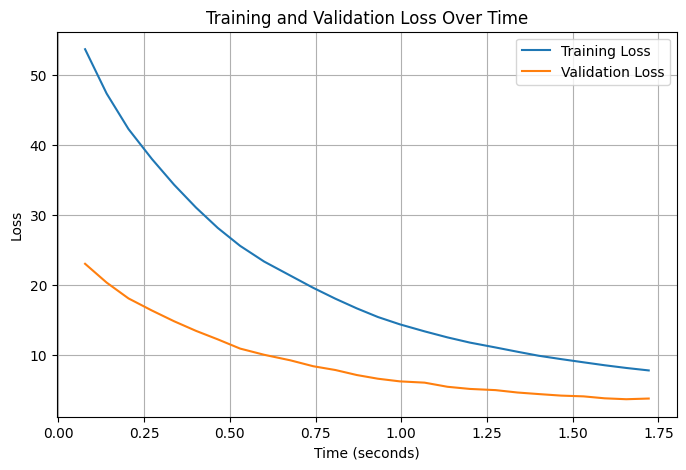

Normalized Confusion Matrix for training dataset


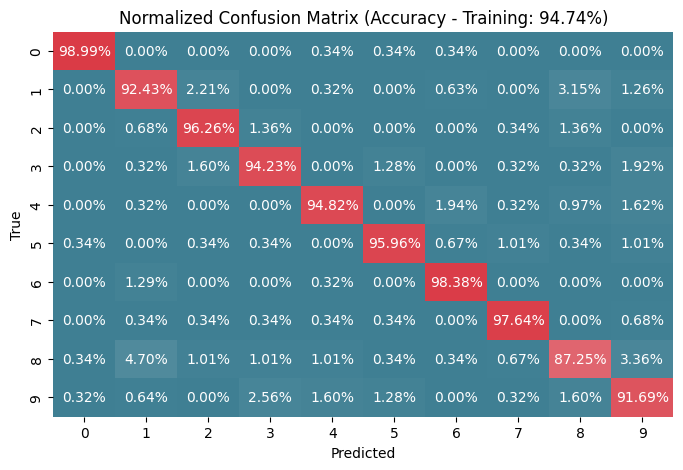

Normalized Confusion Matrix for validation dataset


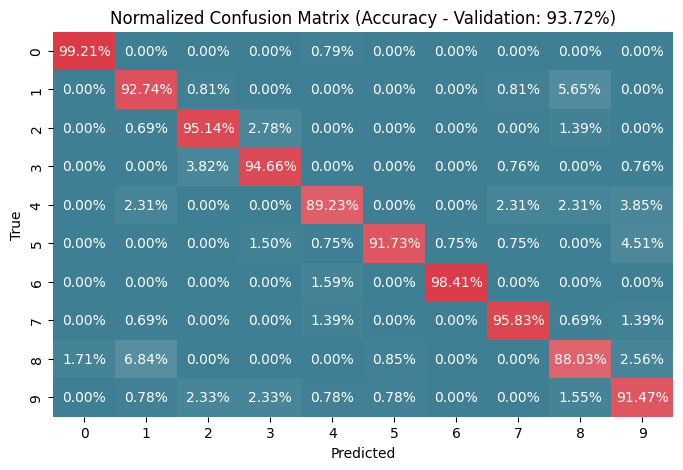

In [108]:
model_10_tanh = nn.Sequential(
          nn.Linear(64, 10),
          nn.Tanh(),
          nn.Linear(10,10)
        )
device = torch.device('cuda') #crea un objeto de dispositivo que representa la GPU

model = model_10_tanh.to(device) #mueve el modelo a la GPU

criterion = nn.CrossEntropyLoss() #se crea una instancia de la función de pérdida nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Se crea un optimizador Adam (un algoritmo de optimización)
                                                          #que se utilizará para ajustar los pesos del modelo durante el entrenamiento.
train_model(model_10_tanh)

epoch 0, Train Loss: 51.935761, Validation Loss: 22.266985, Train Accuracy: 21.76%, Validation Accuracy: 33.56%
epoch 1, Train Loss: 45.748321, Validation Loss: 19.731057, Train Accuracy: 47.21%, Validation Accuracy: 55.40%
epoch 2, Train Loss: 40.738019, Validation Loss: 17.611598, Train Accuracy: 61.41%, Validation Accuracy: 67.51%
epoch 3, Train Loss: 36.581019, Validation Loss: 15.946177, Train Accuracy: 71.10%, Validation Accuracy: 74.10%
epoch 4, Train Loss: 33.014722, Validation Loss: 14.334476, Train Accuracy: 76.96%, Validation Accuracy: 79.23%
epoch 5, Train Loss: 29.885715, Validation Loss: 13.047838, Train Accuracy: 80.83%, Validation Accuracy: 82.53%
epoch 6, Train Loss: 27.154097, Validation Loss: 11.829742, Train Accuracy: 83.53%, Validation Accuracy: 84.60%
epoch 7, Train Loss: 24.694536, Validation Loss: 10.781604, Train Accuracy: 85.77%, Validation Accuracy: 86.44%
epoch 8, Train Loss: 22.521699, Validation Loss: 9.796542, Train Accuracy: 87.51%, Validation Accuracy: 

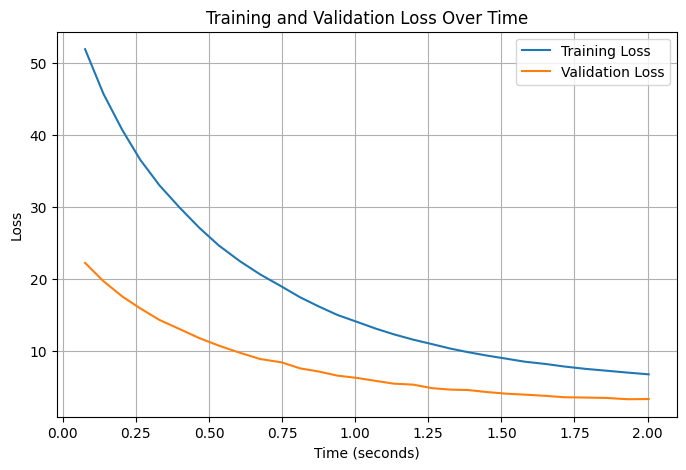

Normalized Confusion Matrix for training dataset


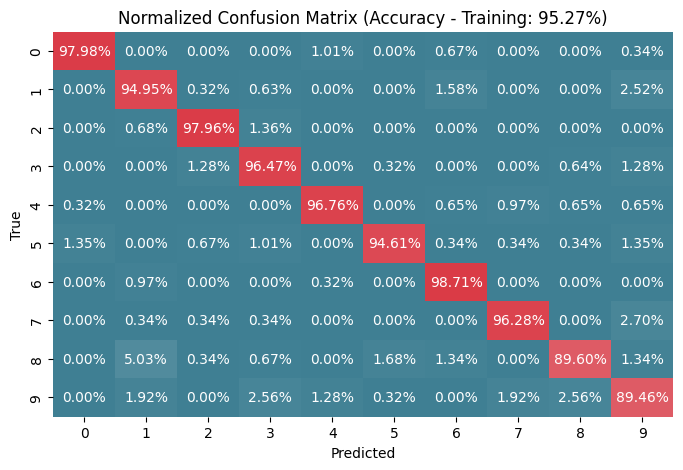

Normalized Confusion Matrix for validation dataset


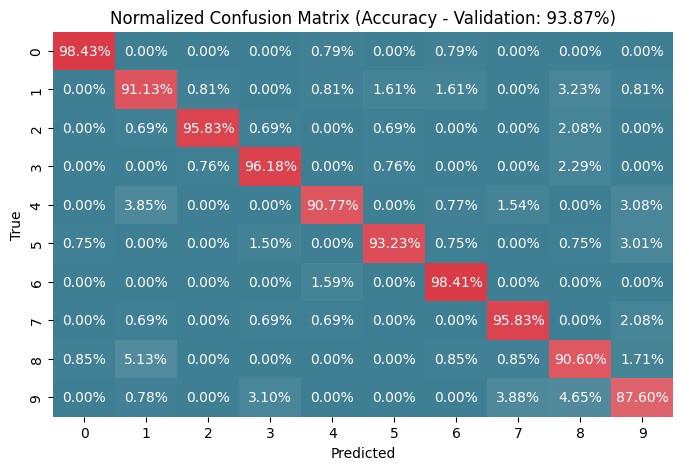

In [109]:
model_40_tanh = nn.Sequential(
          nn.Linear(64, 10),
          nn.Tanh(),
          nn.Linear(10,10)
        )
device = torch.device('cuda') #crea un objeto de dispositivo que representa la GPU

model = model_40_tanh.to(device) #mueve el modelo a la GPU

criterion = nn.CrossEntropyLoss() #se crea una instancia de la función de pérdida nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Se crea un optimizador Adam (un algoritmo de optimización)
                                                          #que se utilizará para ajustar los pesos del modelo durante el entrenamiento.
train_model(model_40_tanh)

epoch 0, Train Loss: 55.359623, Validation Loss: 24.937935, Train Accuracy: 9.80%, Validation Accuracy: 9.27%
epoch 1, Train Loss: 53.351063, Validation Loss: 23.914202, Train Accuracy: 17.49%, Validation Accuracy: 23.07%
epoch 2, Train Loss: 50.122980, Validation Loss: 22.058732, Train Accuracy: 27.05%, Validation Accuracy: 26.82%
epoch 3, Train Loss: 45.371072, Validation Loss: 19.676536, Train Accuracy: 30.47%, Validation Accuracy: 36.32%
epoch 4, Train Loss: 40.150409, Validation Loss: 17.385606, Train Accuracy: 44.64%, Validation Accuracy: 56.32%
epoch 5, Train Loss: 34.918749, Validation Loss: 14.972967, Train Accuracy: 59.04%, Validation Accuracy: 65.82%
epoch 6, Train Loss: 30.069201, Validation Loss: 12.800305, Train Accuracy: 66.93%, Validation Accuracy: 68.74%
epoch 7, Train Loss: 25.845706, Validation Loss: 10.978692, Train Accuracy: 70.55%, Validation Accuracy: 71.19%
epoch 8, Train Loss: 22.335617, Validation Loss: 9.574666, Train Accuracy: 73.64%, Validation Accuracy: 74

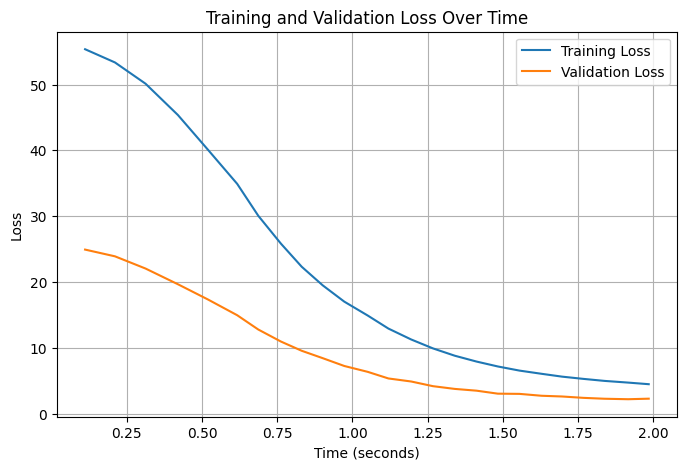

Normalized Confusion Matrix for training dataset


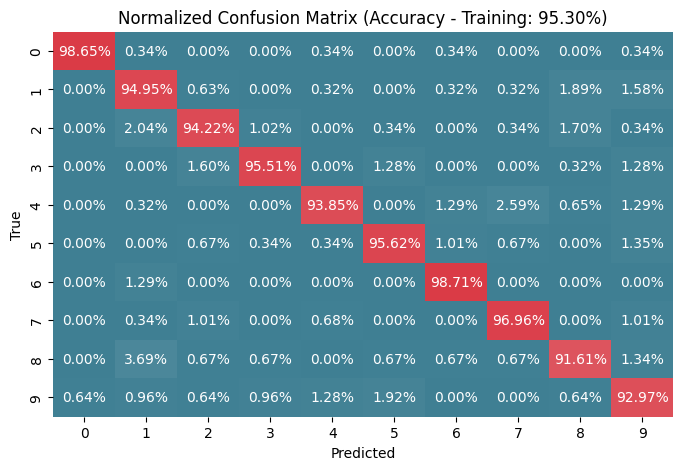

Normalized Confusion Matrix for validation dataset


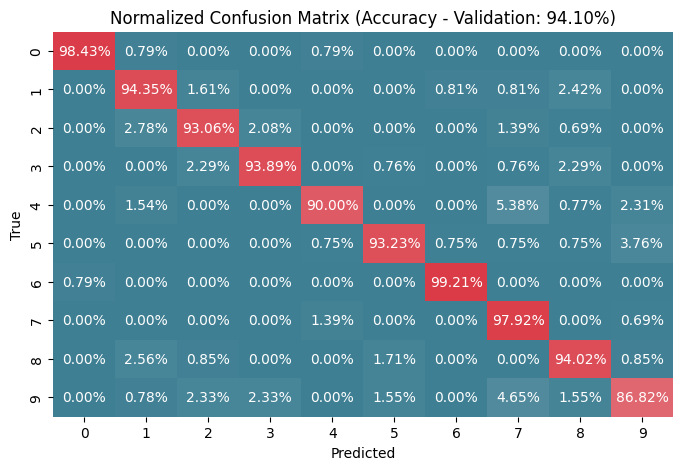

In [110]:
model_2o_10_ReLU = nn.Sequential(
    nn.Linear(64, 10),  # Primera capa oculta con 10 neuronas
    nn.ReLU(),                  # Función de activación ReLU
    nn.Linear(10, 10),          # Segunda capa oculta con 10 neuronas
    nn.ReLU(),                  # Función de activación ReLU
    nn.Linear(10, 10)  # Capa de salida (ajusta 'out_features' según tu problema)
)
device = torch.device('cuda') #crea un objeto de dispositivo que representa la GPU

model = model_2o_10_ReLU.to(device) #mueve el modelo a la GPU

criterion = nn.CrossEntropyLoss() #se crea una instancia de la función de pérdida nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Se crea un optimizador Adam (un algoritmo de optimización)
                                                          #que se utilizará para ajustar los pesos del modelo durante el entrenamiento.
train_model(model_2o_10_ReLU)

epoch 0, Train Loss: 52.285783, Validation Loss: 22.203562, Train Accuracy: 46.38%, Validation Accuracy: 67.66%
epoch 1, Train Loss: 43.004289, Validation Loss: 16.474935, Train Accuracy: 68.67%, Validation Accuracy: 70.96%
epoch 2, Train Loss: 28.316866, Validation Loss: 9.384677, Train Accuracy: 75.08%, Validation Accuracy: 80.84%
epoch 3, Train Loss: 16.145533, Validation Loss: 5.370569, Train Accuracy: 84.78%, Validation Accuracy: 88.81%
epoch 4, Train Loss: 9.904753, Validation Loss: 3.583876, Train Accuracy: 90.96%, Validation Accuracy: 93.03%
epoch 5, Train Loss: 6.840536, Validation Loss: 2.744886, Train Accuracy: 93.49%, Validation Accuracy: 94.18%
epoch 6, Train Loss: 5.267152, Validation Loss: 2.187034, Train Accuracy: 94.97%, Validation Accuracy: 95.33%
epoch 7, Train Loss: 4.281860, Validation Loss: 1.837811, Train Accuracy: 95.96%, Validation Accuracy: 95.48%
epoch 8, Train Loss: 3.650861, Validation Loss: 1.683128, Train Accuracy: 96.32%, Validation Accuracy: 95.86%
epoc

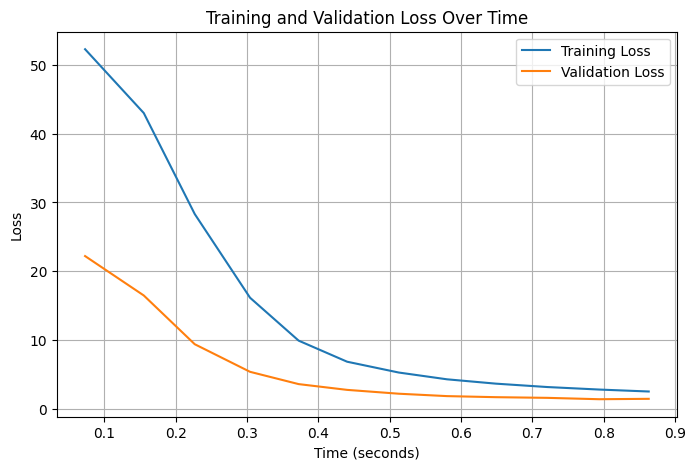

Normalized Confusion Matrix for training dataset


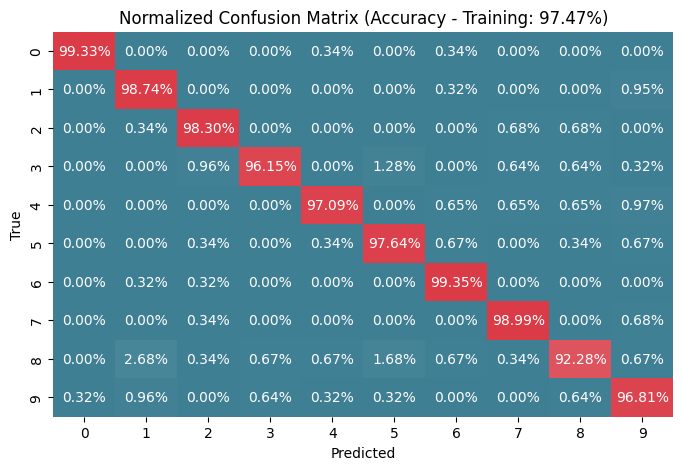

Normalized Confusion Matrix for validation dataset


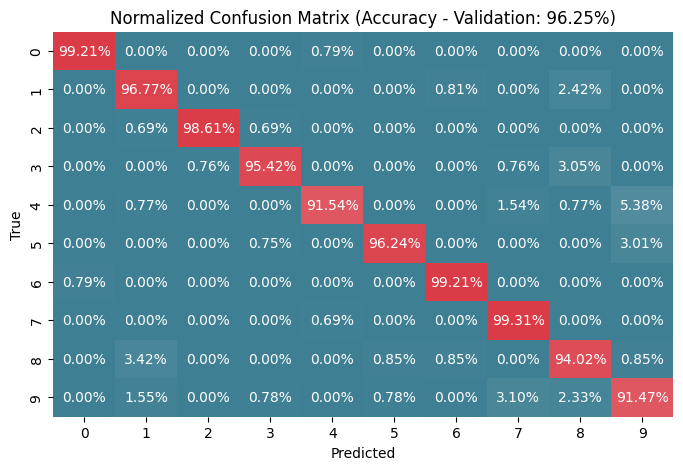

In [111]:
model_2o_40_ReLU = nn.Sequential(
    nn.Linear(64, 40),  # Primera capa oculta con 10 neuronas
    nn.ReLU(),                  # Función de activación ReLU
    nn.Linear(40, 40),          # Segunda capa oculta con 10 neuronas
    nn.ReLU(),                  # Función de activación ReLU
    nn.Linear(40, 10)  # Capa de salida (ajusta 'out_features' según tu problema)
)
device = torch.device('cuda') #crea un objeto de dispositivo que representa la GPU

model = model_2o_40_ReLU.to(device) #mueve el modelo a la GPU

criterion = nn.CrossEntropyLoss() #se crea una instancia de la función de pérdida nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Se crea un optimizador Adam (un algoritmo de optimización)
                                                          #que se utilizará para ajustar los pesos del modelo durante el entrenamiento.
train_model(model_2o_40_ReLU)

In [112]:
def train_model_best_accuracy(model_to_train):
    # Listas para almacenar el loss y el tiempo
    train_losses = []
    val_losses = []
    times = []

    # Inicialización de variables para el seguimiento del loss de validación
    prev_val_loss = float('inf')  # Inicialmente, un valor alto
    prev_train_loss = float('-inf') # Inicialmente, un valor bajo
    start = time.time()

    for epoch in range(1000):
        all_predictions_train = []
        all_labels_train = []
        model_to_train.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(dataloader_train, 0):
            # Process the current batch
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model_to_train(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calcula la precisión en entrenamiento
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_predictions_train.extend(predicted.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())

        train_accuracy = 100 * correct_train / total_train

        # Mueve las predicciones y etiquetas a NumPy arrays
        predicted_train = np.array(all_predictions_train)
        labels_train = np.array(all_labels_train)

        # Calcula la matriz de confusión en la GPU
        confusion_matrix_train = confusion_matrix(labels_train, predicted_train, normalize="true")

        all_predictions_val = []
        all_labels_val = []

        model_to_train.eval()
        with torch.no_grad():
            val_loss = 0.0
            correct_val = 0
            total_val = 0

            for i, data in enumerate(dataloader_val, 0):
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model_to_train(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calcula la precisión en validación
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_predictions_val.extend(predicted.cpu().numpy())
                all_labels_val.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct_val / total_val

        # Mueve las predicciones y etiquetas a NumPy arrays
        predicted_gpu = np.array(all_predictions_val)
        labels_gpu = np.array(all_labels_val)

        # Calcula la matriz de confusión en la GPU
        confusion_matrix_val = confusion_matrix(labels_gpu, predicted_gpu, normalize="true")

                # Matriz de confusión para el conjunto de prueba
        all_predictions_test = []
        all_labels_test = []

        model_to_train.eval()
        with torch.no_grad():
            for i, data in enumerate(dataloader_test, 0):
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model_to_train(inputs)
                _, predicted = torch.max(outputs, 1)
                all_predictions_test.extend(predicted.cpu().numpy())
                all_labels_test.extend(labels.cpu().numpy())

        # Mueve las predicciones y etiquetas a NumPy arrays
        predicted_test = np.array(all_predictions_test)
        labels_test = np.array(all_labels_test)

        # Calcula la matriz de confusión en la GPU
        confusion_matrix_test = confusion_matrix(labels_test, predicted_test, normalize="true")


        # Comprueba si el loss de validación aumentó y el de entrenamiento bajó
        if val_loss > prev_val_loss and train_loss < prev_train_loss:
            print('Deteniendo el entrenamiento en la época %d, debido al aumento en el loss de validación y la disminución en el loss de entrenamiento.' % (epoch))
            break

        prev_val_loss = val_loss
        prev_train_loss = train_loss

        # Agrega el loss y el tiempo a las listas
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        times.append(time.time() - start)

        # Imprime el loss de entrenamiento y validación, así como las precisiones
        print('epoch %d, Train Loss: %.6f, Validation Loss: %.6f, Train Accuracy: %.2f%%, Validation Accuracy: %.2f%%' % (epoch, train_loss, val_loss, train_accuracy, val_accuracy))

    end = time.time()

    print('Finished Training, total time %f seconds' % (end - start))

        # Crear una paleta de colores personalizada con una resistencia más baja
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    print("Normalized Confusion Matrix for test dataset")
    plt.figure(figsize=(8, 5))
    sns.heatmap(confusion_matrix_test, annot=True, cmap=cmap, fmt=".2%", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    test_accuracy = accuracy_score(labels_test, predicted_test)
    plt.title('Normalized Confusion Matrix (Accuracy - Test: {:.2f}%)'.format(test_accuracy * 100))
    plt.show()


epoch 0, Train Loss: 52.442060, Validation Loss: 22.240459, Train Accuracy: 31.23%, Validation Accuracy: 56.09%
epoch 1, Train Loss: 42.725096, Validation Loss: 16.285577, Train Accuracy: 67.36%, Validation Accuracy: 73.56%
epoch 2, Train Loss: 27.741990, Validation Loss: 9.281032, Train Accuracy: 78.34%, Validation Accuracy: 83.91%
epoch 3, Train Loss: 15.703508, Validation Loss: 5.634767, Train Accuracy: 86.88%, Validation Accuracy: 89.73%
epoch 4, Train Loss: 9.556716, Validation Loss: 3.625704, Train Accuracy: 91.06%, Validation Accuracy: 92.72%
epoch 5, Train Loss: 6.713233, Validation Loss: 2.813267, Train Accuracy: 92.83%, Validation Accuracy: 94.10%
epoch 6, Train Loss: 5.170115, Validation Loss: 2.321906, Train Accuracy: 94.35%, Validation Accuracy: 95.02%
epoch 7, Train Loss: 4.239397, Validation Loss: 1.949174, Train Accuracy: 95.73%, Validation Accuracy: 95.48%
epoch 8, Train Loss: 3.597951, Validation Loss: 1.674084, Train Accuracy: 96.42%, Validation Accuracy: 95.63%
epoc

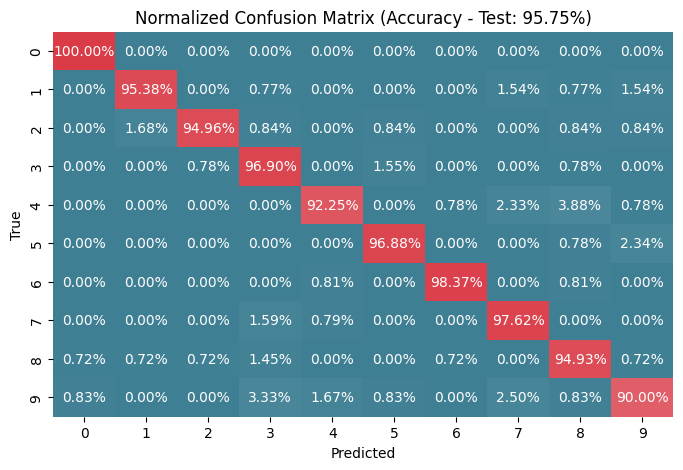

In [113]:
model_2o_40_ReLU = nn.Sequential(
    nn.Linear(64, 40),  # Primera capa oculta con 10 neuronas
    nn.ReLU(),                  # Función de activación ReLU
    nn.Linear(40, 40),          # Segunda capa oculta con 10 neuronas
    nn.ReLU(),                  # Función de activación ReLU
    nn.Linear(40, 10)  # Capa de salida (ajusta 'out_features' según tu problema)
)
device = torch.device('cuda') #crea un objeto de dispositivo que representa la GPU

model = model_2o_40_ReLU.to(device) #mueve el modelo a la GPU

criterion = nn.CrossEntropyLoss() #se crea una instancia de la función de pérdida nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Se crea un optimizador Adam (un algoritmo de optimización)
                                                          #que se utilizará para ajustar los pesos del modelo durante el entrenamiento.
train_model_best_accuracy(model_2o_40_ReLU)